## AGN Time Lags metric

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

In [3]:
baseline_file = get_baseline()
runName = os.path.split(baseline_file)[-1].replace('.db', '')

opsdb = maf.OpsimDatabase(baseline_file)
print(runName)

baseline_v2.1_10yrs


The AGN TimeLag metric looks at the timing of visits and calculates the (mean, min or max) of the interval between visits. This difference is then compared to the time interval required for nyquist sampling over the 'time lag' period. The value of `time lag / (1 + z + time interval` is returned, if it is above the nyquist threshold of 2.2.

There are modest magnitude limit cuts in g and r bands before a visit is counted, but no other bandpasses. Most short visits will be counted.

In [4]:
# Run the TimeLag for each filter *and* all filters
nside = 64
filterlist, colors, filterorders, filtersqls, filterinfo_label = maf.filterList(
    all=True,
)
slicer = maf.HealpixSlicer(nside=nside, useCache=False)
dustmap = maf.DustMap(nside=nside)
displayDict = {}
bundleList = []

nquist_threshold = 2.2
lag = 100
summaryMetrics = maf.extendedSummary()
summaryMetrics += [maf.AreaThresholdMetric(lower_threshold=nquist_threshold)]
m = maf.AGN_TimeLagMetric(threshold=nquist_threshold, lag=lag)
for f in filterlist:
    plotDict = {"color": colors[f], "colorMin": 0, "colorMax": 5, "percentileClip": 95}
    displayDict["order"] = filterorders[f]
    displayDict["subgroup"] = "Time Lags"
    displayDict["caption"] = (
        f"Comparion of the time between visits compared to a defined sampling gap ({lag} days) in "
        f"{f} band."
    )
    bundleList.append(
        maf.MetricBundle(
            m,
            slicer,
            constraint=filtersqls[f],
            info_label=filterinfo_label[f],
            runName=runName,
            mapsList=[dustmap],
            plotDict=plotDict,
            summaryMetrics=summaryMetrics,
            displayDict=displayDict,
        )
    )
bundles = maf.makeBundlesDictFromList(bundleList)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [5]:
g = maf.MetricBundleGroup(bundles, opsdb, 'temp', None)
g.runAll()

Querying table None with no constraint for columns ['rotSkyPos', 'fieldRA', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'filter'].
Found 2081749 visits
Running:  ['baseline_v2_1_10yrs_AGN_TimeLag_100_days_all_bands_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "y" for columns ['rotSkyPos', 'fieldRA', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'filter']
Found 390128 visits
Running:  ['baseline_v2_1_10yrs_AGN_TimeLag_100_days_y_band_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "u" for columns ['rotSkyPos', 'fieldRA', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'filter']
Found 134868 visits
Running:  ['baseline_v2_1_10yrs_AGN_TimeLag_100_days_u_band_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None w

0.0 180.0 -180.0 180.0
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 9834 bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 591 bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 74405 bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 104886 bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 634789 bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0
/Users/lynnej/lsst_repos/rubin_si

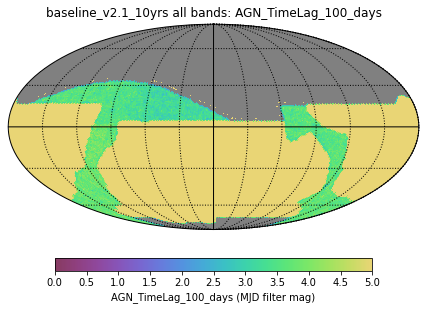

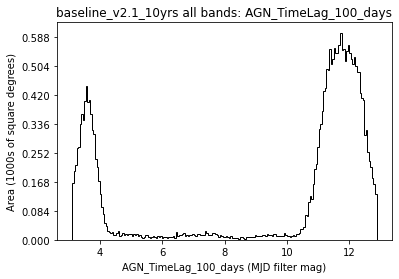

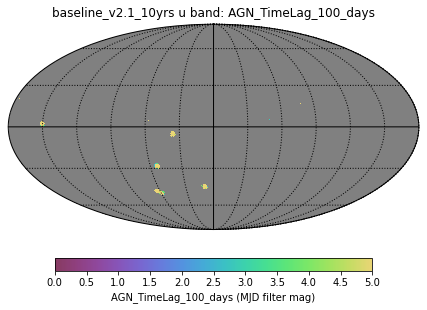

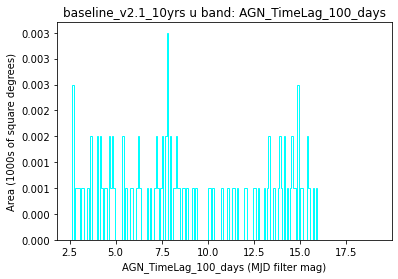

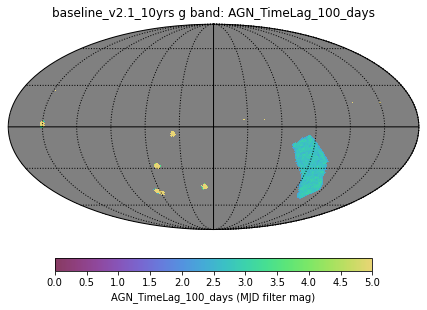

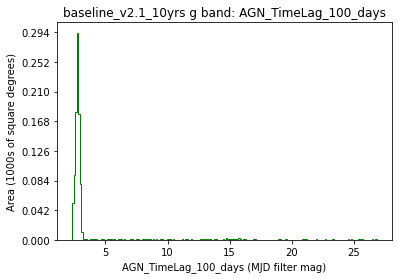

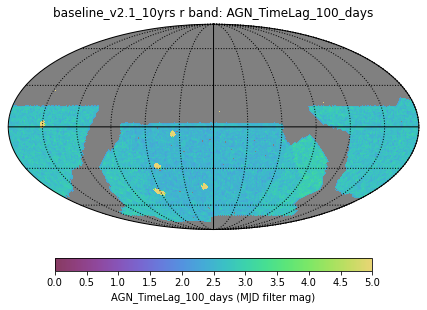

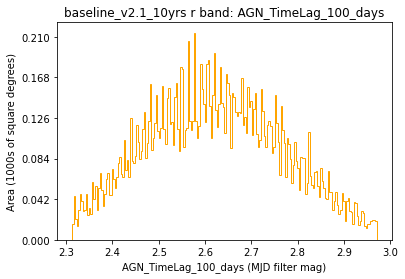

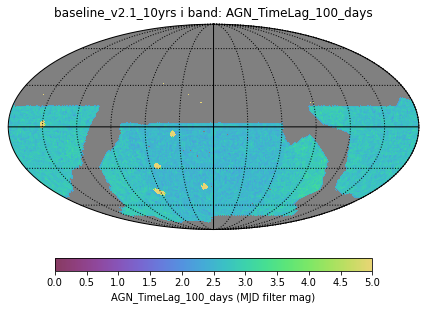

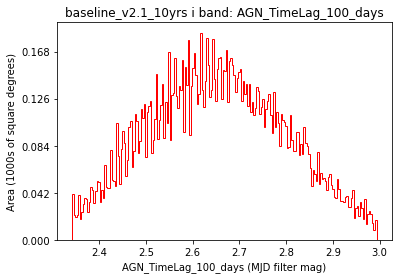

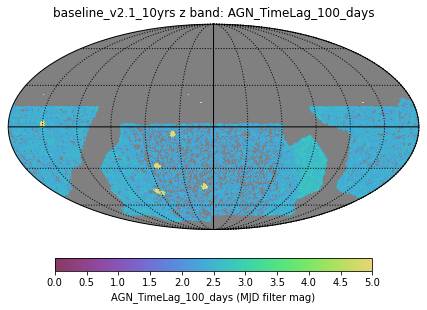

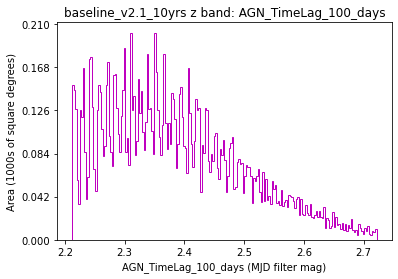

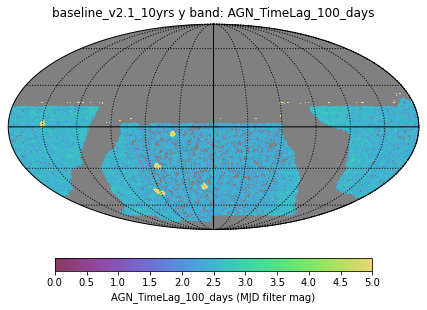

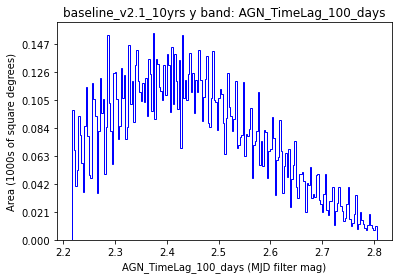

In [6]:
for k in bundles:
    bundles[k].plot()

Compare results across a variety of runs.

In [20]:
# Variance across (most of) current set of simulations?
summaries = maf.get_metric_summaries()
families = maf.get_family_descriptions()
metric_sets = maf.get_metric_sets()

In [21]:
fams = [f for f in families.index if not f.startswith('ddf')]
runs = families.explode(['run']).loc[fams]['run']

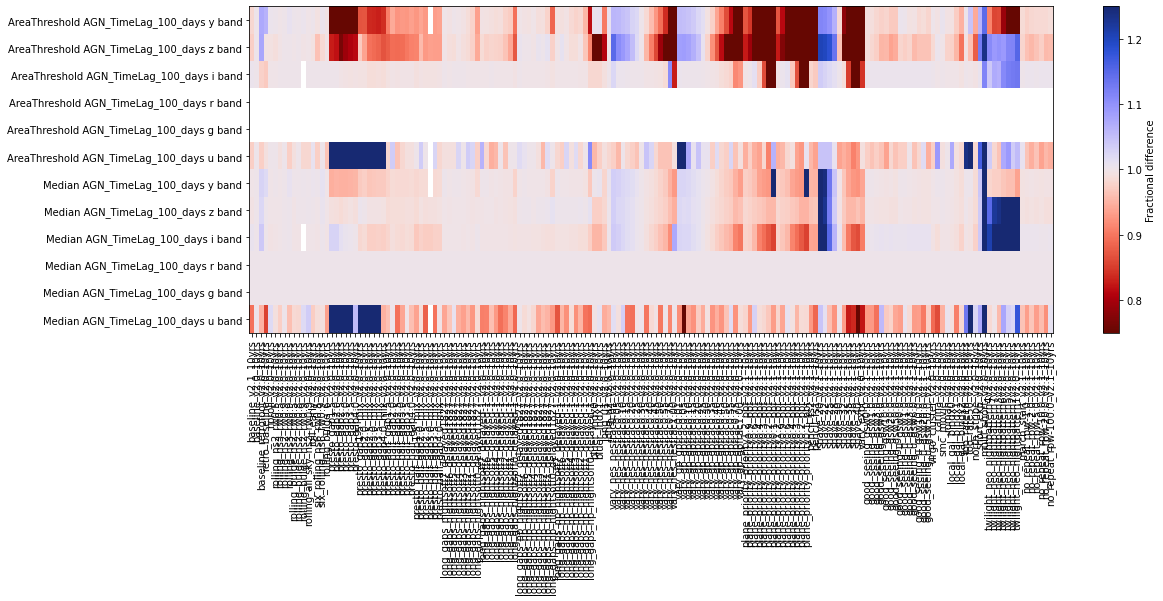

In [22]:
# Plot the *normalized* values
k = 'AGN timelag'
fig, ax = maf.plot_run_metric_mesh(summaries.loc[runs, metric_sets.loc[k]['metric']], 
                                   baseline_run='baseline_v2.0_10yrs',
                                  color_range=0.5,
                                   metric_label_map=metric_sets.loc[k]['short_name'],
                                  metric_set=metric_sets.loc[k])
fig.set_figwidth(18)

(0.5, 1.5)

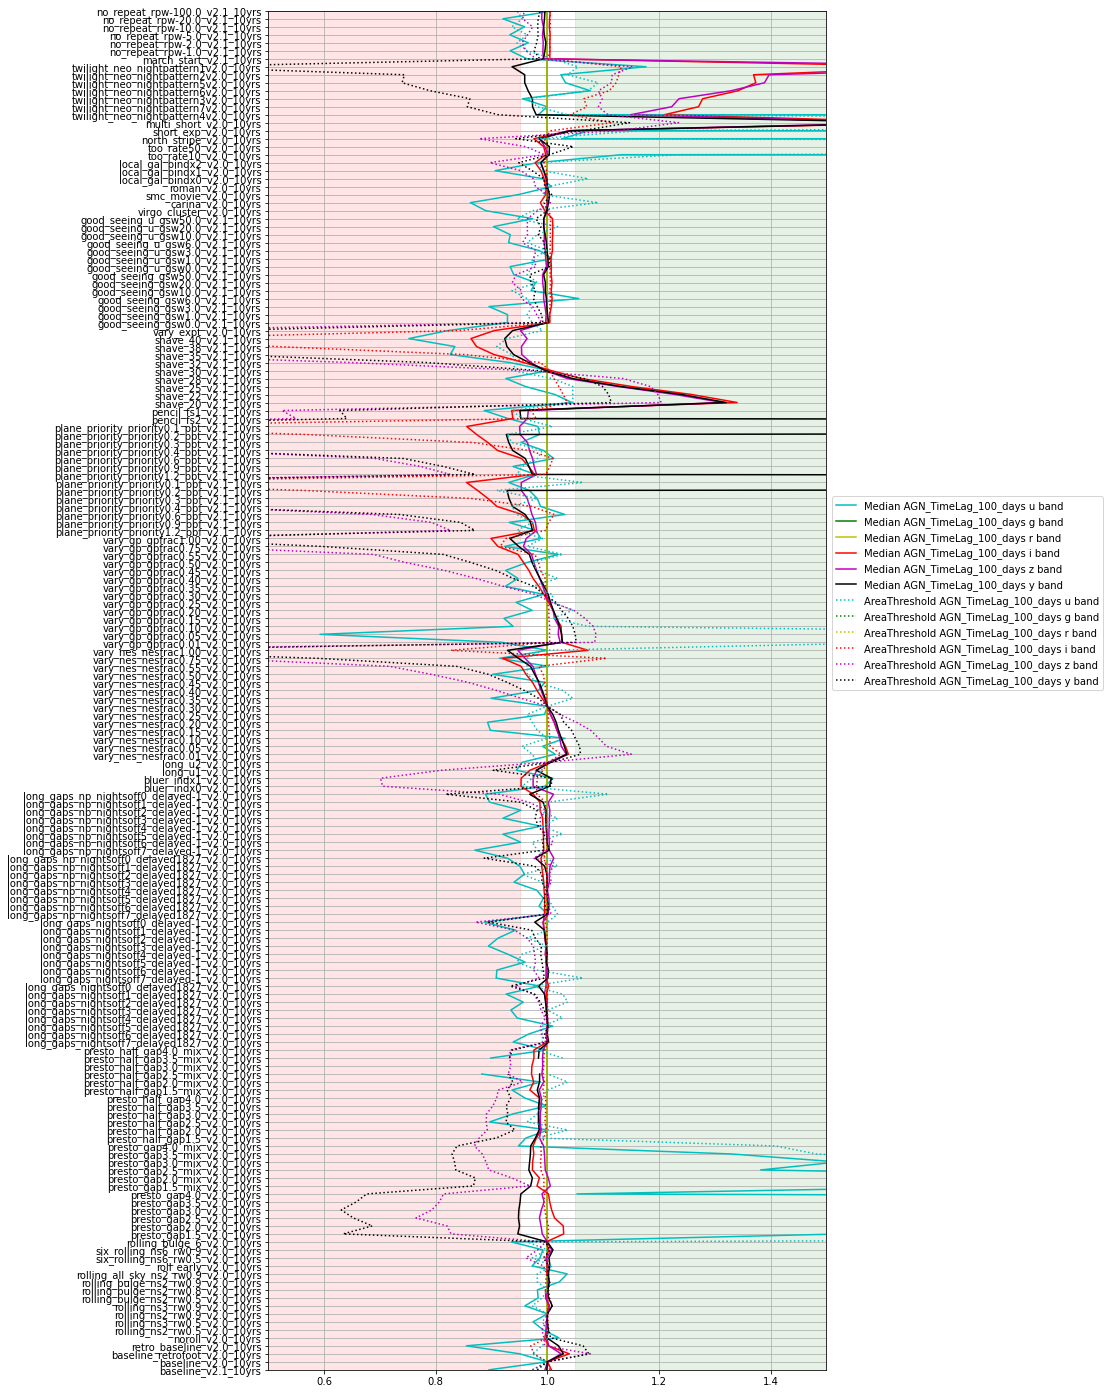

In [24]:
# Plot the normalized values, in a different way
fig, ax = maf.plot_run_metric(summaries.loc[runs, metric_sets.loc[k]['metric']],
                             baseline_run='baseline_v2.0_10yrs',
                             metric_label_map=metric_sets.loc[k]['short_name'],
                             metric_set=metric_sets.loc[k],
                             horizontal_quantity='value',
                             vertical_quantity='run')
fig.set_figheight(25)
ax.legend(loc=(1.01, 0.5))
ax.set_xlim(0.5, 1.5)